In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, DetCurveDisplay

In [32]:
def assign_cluster(X,centroid):
  d = 0 #Distortion
  clusters = {i: [] for i in range(len(centroid))}
  for i in range(len(X)):
    euc_dist=[]
    for j in range(len(centroid)):
      euc_dist.append(np.linalg.norm(X[i]-centroid[j]))
    min_ind = np.argmin(euc_dist)
    d += min(euc_dist)
    clusters[min_ind].append(X[i])
  '''for i in range(len(centroid)):
    clusters[i]=np.array(clusters[i])'''
  return clusters , d/len(X)

def calc_centroid(centroid,clusters,n_clusters):
  for i in range(n_clusters):
    centroid[i] = np.mean(clusters[i], axis=0)
  #print(centroid)
  return centroid

def plot_(centroid,clusters,n_clusters):
    for i in range(n_clusters):
      plt.scatterplot(clusters[i][:][0],clusters[i][:][1])
      plt.legend(str(i))

def k_means(X,n_clusters,max_iter=20,thresh=0.01):
  print('---------------No of cluster :',n_clusters)
  k = n_clusters

  # Initialize Centroids Randomly 
  centroid_ind = random.sample(range(len(X)),k)
  centroid = []  
  for i in range(k):
    centroid.append(X[centroid_ind[i]]) 
  centroid = np.array(centroid)
  #print('Initial Centroid :',centroid)

  # Assigning Clusters 
  clusters, distortion = assign_cluster(X,centroid)

  #Recalculating Centroids
  prev_centroid = centroid.copy()
  centroid = calc_centroid(centroid,clusters,n_clusters)
  #print('prev : ',prev_centroid,'new : ',centroid)
  #print('diff  :  ',np.linalg.norm(prev_centroid-centroid))
  max_iter-=1

  while (np.linalg.norm(prev_centroid-centroid)>=thresh and max_iter>=0):
    max_iter-=1
    clusters,distortion =assign_cluster(X,centroid)
    prev_centroid = centroid.copy()
    centroid = calc_centroid(centroid,clusters,n_clusters)
    #print('diff  :  ',np.linalg.norm(prev_centroid-centroid))

  return clusters,centroid,distortion

In [33]:
def get_sequence(arr, centroids):
    n = arr.shape[0]
    seq = []
    for i in range(n):
        cluster = np.argmin(np.sum((centroids - arr[i, :])**2, axis = 1))
        seq.append(cluster)
    return seq

def get_symbols(dir, nc, centroids):
    s_vector = []
    files = os.listdir(dir)
    for file in files:
        if '.mfcc' in file:
            arr = np.loadtxt(dir + file, skiprows = 1)
            # nf = arr[0]
            # arr_res = np.reshape(arr, (int(nf), nc))
            seq = get_sequence(arr, centroids)
            s_vector.append(seq)
    return s_vector

In [34]:
def get_features(dir, nc):
    f_vector = []
    files = os.listdir(dir)
    for file in files:
        if '.mfcc' in file:
            arr = np.loadtxt(dir + file, skiprows = 1)
            # nf = arr[0]
            # arr_res = np.reshape(arr, (int(nf), nc))
            f_vector.append(arr)
    return np.concatenate(f_vector, axis = 0)

In [35]:
NC = 38
classes = [0, 1, 2, 3, 4]
a_train_dir = 'Isolated digits/1/train/'
ai_train_dir = 'Isolated digits/2/train/'
ba_train_dir = 'Isolated digits/4/train/'
da_train_dir = 'Isolated digits/9/train/'
la_train_dir = 'Isolated digits/o/train/'
train_dir = [a_train_dir, ai_train_dir, ba_train_dir, da_train_dir, la_train_dir]

In [36]:
features = []
for dir in train_dir:
    f_vector = get_features(dir, NC)
    features.append(f_vector)
features = np.concatenate(features, axis = 0)

In [37]:
features.shape

(18552, 38)

In [38]:
n_clusters = 20
clusters, centroid, distortion = k_means(features, n_clusters, max_iter = 20, thresh = 0.01)

---------------No of cluster : 20


In [41]:
centroid.shape

(20, 38)

In [42]:
a_s_vector = get_symbols(a_train_dir, NC, centroid)
ai_s_vector = get_symbols(ai_train_dir, NC, centroid)
ba_s_vector = get_symbols(ba_train_dir, NC, centroid)
da_s_vector = get_symbols(da_train_dir, NC, centroid)
la_s_vector = get_symbols(la_train_dir, NC, centroid)

train = [a_s_vector, ai_s_vector, ba_s_vector, da_s_vector, la_s_vector]

### Dynamic Time Warping

In [43]:
def DTW(s1, s2):
    n = len(s1)
    m = len(s2)
    matrix = [[np.inf]*(m + 1) for _ in range(n + 1)]
    matrix[0][0] = 0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i - 1] - s2[j - 1])
            matrix[i][j] = cost + min(matrix[i - 1][j], matrix[i][j - 1], matrix[i - 1][j - 1])
    return matrix[n][m]

def get_score(s, X):
    n = len(X)
    scores = []
    for i in range(n):
        scores.append(DTW(s, X[i]))
    return np.mean(scores)
    
def classify_DTW(X, train):
    n = len(X)
    c = len(train)
    pred = np.zeros((n, c))
    for i in range(n):
        scores = []
        for j in range(c):
            score = get_score(X[i], train[j])
            scores.append(score)
        pred[i, :] = scores
    pred_target = np.argmin(pred, axis = 1)
    return pred, pred_target

In [44]:
dev_a = get_symbols('Isolated digits/1/dev/', NC, centroid)
dev_ai = get_symbols('Isolated digits/2/dev/', NC, centroid)
dev_ba = get_symbols('Isolated digits/4/dev/', NC, centroid)
dev_da = get_symbols('Isolated digits/9/dev/', NC, centroid)
dev_la = get_symbols('Isolated digits/o/dev/', NC, centroid)

In [45]:
pred_a, pred_target_a = classify_DTW(dev_a, train)
pred_ai, pred_target_ai = classify_DTW(dev_ai, train)
pred_ba, pred_target_ba = classify_DTW(dev_ba, train)
pred_da, pred_target_da = classify_DTW(dev_da, train)
pred_la, pred_target_la = classify_DTW(dev_la, train)

In [46]:
y = pd.Series([0]*12 + [1]*12 + [2]*12 + [3]*12 + [4]*12)
scores = np.concatenate([pred_a, pred_ai, pred_ba, pred_da, pred_la], axis = 0)
y_pred = np.concatenate([pred_target_a, pred_target_ai, pred_target_ba, pred_target_da, pred_target_la], axis = 0)

In [47]:
def evaluate_classifier(y, scores, thresh = 0.5):
    enc = OneHotEncoder()
    y_sparse = enc.fit_transform(y.to_numpy().reshape(-1, 1)).toarray()
    prob = scores/np.sum(scores, axis = -1)[:, np.newaxis]
    n, c = prob.shape
    cm = np.zeros((2, 2))
    for i in range(c):
        col = []
        for j in range(y.shape[0]):
            if prob[j, i] <= thresh:
                col.append(1)
            else:
                col.append(0)
        cm += confusion_matrix(y_sparse[:, i], col)
    tpr = cm[1, 1]/(cm[1, 1] + cm[1, 0])
    fpr = cm[0, 1]/(cm[0, 1] + cm[0, 0])
    return tpr, fpr, cm

def compute_ROC(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    tpr, fpr = [], []
    for thresh in threshold:
        a, b, _ = evaluate_classifier(y, scores, thresh = thresh)
        tpr.append(a)
        fpr.append(b)
    return tpr, fpr, threshold

def compute_DET(y, scores, h = 0.05):
    threshold = [i*h for i in range(int(1/h + 1))]
    fpr, fnr = [], []
    for thresh in threshold:
        _, b, cm = evaluate_classifier(y, scores, thresh = thresh)
        fpr.append(b)
        fnr.append(cm[1, 0]/(cm[1, 0] + cm[1, 1]))
    return fpr, fnr, threshold

def plot_confusion_matrix(y, pred, classes, title = 'Development Set'):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(5, 4))
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y, pred), annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix - ' + title, fontsize=20)
    plt.show()

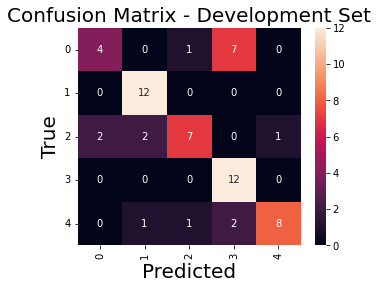

In [48]:
plot_confusion_matrix(y, y_pred, classes = classes)

In [49]:
tpr, fpr, _ = compute_ROC(y, scores)
fpr, fnr, _ = compute_DET(y, scores)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


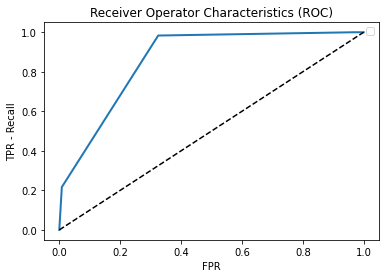

In [50]:
plt.plot(fpr, tpr, linewidth = 2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR - Recall')
plt.title('Receiver Operator Characteristics (ROC)')
plt.legend()
plt.show()

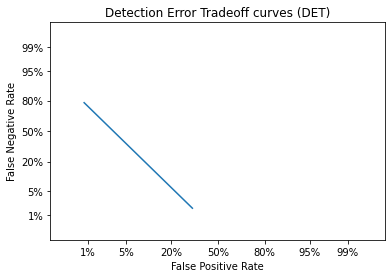

In [51]:
fig, axs = plt.subplots()
DetCurveDisplay(fpr = fpr, fnr = fnr).plot(ax = axs)
plt.title('Detection Error Tradeoff curves (DET)')
plt.show()